<a href="https://colab.research.google.com/github/MauricioUhlig/trabalhos_redes_neurais/blob/main/MNIST_convolucional_com_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação do MNIST em rede convolucional usando Keras

In [1]:
import os
import kagglehub
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

## Donwload e pre-processamento

In [2]:
# Download
path = kagglehub.dataset_download("hojjatk/mnist-dataset")
print(path)

def load_images(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28, 28, 1)

def load_labels(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

X_train = load_images('/kaggle/input/mnist-dataset/train-images.idx3-ubyte')
y_train = load_labels('/kaggle/input/mnist-dataset/train-labels.idx1-ubyte')
X_test = load_images('/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte')
y_test = load_labels('/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte')

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

/kaggle/input/mnist-dataset
Training data shape: (60000, 28, 28, 1)
Training labels shape: (60000, 10)
Test data shape: (10000, 28, 28, 1)
Test labels shape: (10000, 10)


## Criação do modelo

In [3]:
class Divide255(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X / 255.0

class Shape2Keras(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X.reshape(-1, 28, 28, 1)

In [4]:
def KerasCNN2D(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.Flatten()(x)
  outputs = layers.Dense(num_classes, activation="softmax")(x)
  return keras.Model(inputs=inputs, outputs=outputs)

model = KerasCNN2D((28, 28, 1), 10)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,202 (407.04 KB)

 Trainable params: 104,202 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

## Criação do Wrapper

In [5]:
class KerasWrappedNN(BaseEstimator, ClassifierMixin):
  def __init__(self, epochs=5, batch_size=128, model_fabric=KerasCNN2D):
    self.epochs = epochs
    self.batch_size = batch_size
    self.model_fabric = model_fabric
    self.history = None

  def fit(self, X, y):
    if y.ndim > 1 and y.shape[1] > 2:
        yhot = y
        self.labels = np.arange(y.shape[1])
        num_classes = y.shape[1]
    else:
        self.labels, ids = np.unique(y, return_inverse=True)
        yhot = keras.utils.to_categorical(ids, len(self.labels))
        num_classes = len(self.labels)

    self.model = self.model_fabric(X.shape[1:], num_classes)
    self.model.compile(optimizer="rmsprop",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])
    self.history = self.model.fit(X, yhot, epochs=self.epochs, batch_size=self.batch_size)
    return self

  def predict(self, X):
    probabilities = self.model.predict(X)
    return self.labels[np.argmax(probabilities, axis=1)]

## Criação do pipeline e execução do treinamento

In [6]:
# Criação do pipeline e execução

epochs = 10

model = Pipeline([
    ("scaler", Divide255()),
    ("reshaper", Shape2Keras()),
    ("model", KerasWrappedNN(model_fabric=KerasCNN2D, epochs=epochs))
])

model.fit(X_train, y_train)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1155 - loss: 2.3013
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2621 - loss: 2.0630
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8382 - loss: 0.5314
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8899 - loss: 0.3567
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9253 - loss: 0.2401
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9493 - loss: 0.1654
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9619 - loss: 0.1244
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9677 - loss: 0.1051
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9730 - loss: 0.0861
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9765 - loss: 0.0745


Pipeline(steps=[('scaler', Divide255()), ('reshaper', Shape2Keras()),
                ('model', KerasWrappedNN(epochs=10))])

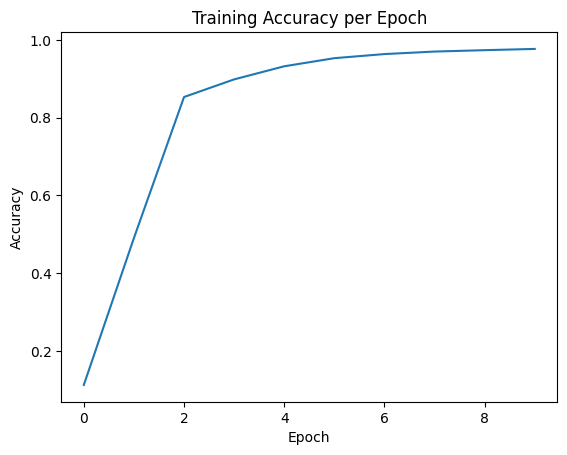

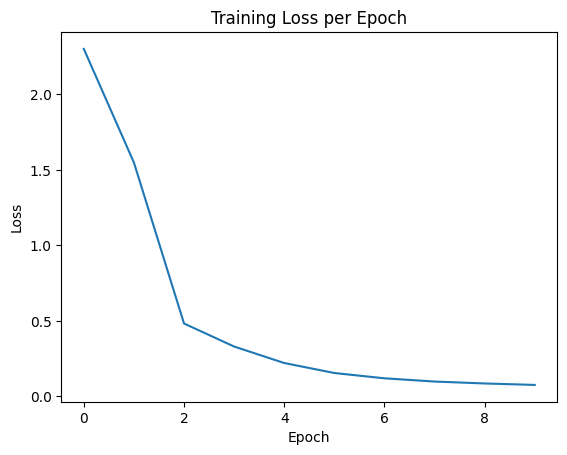

In [7]:
keras_wrapper = model.named_steps['model']
training_history = keras_wrapper.history

train_accuracy_history = training_history.history['accuracy']
plt.plot(train_accuracy_history)
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

train_loss_history = training_history.history['loss']
plt.plot(train_loss_history)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Execução do teste

In [8]:
ypred = model.predict(X_test)

y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, ypred)

print(f"Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9799


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
